## Decscriton

This notebook is for classification of breast cancer with data from https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

In [24]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns

##SVM

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
url = "wdbc.data"
data = pd.read_csv(url, header=None)

In [12]:
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values
y = (y == 'M').astype(int) * 2 - 1  # Convert labels to +1 (Malignant) and -1 (Benign)

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [7]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [27]:
def rbf_kernel(X1, X2, gamma=0.1):
    dist_matrix = torch.cdist(X1, X2) ** 2
    return torch.exp(-gamma * dist_matrix)

In [28]:
class SVM_RBF(nn.Module):
    def __init__(self, X_train, gamma=0.1):
        super(SVM_RBF, self).__init__()
        self.X_train = X_train
        self.alpha = nn.Parameter(torch.randn(X_train.shape[0], 1))
        self.gamma = gamma

    def forward(self, X):
        K = rbf_kernel(X, self.X_train, self.gamma)
        return torch.mm(K, self.alpha)

In [29]:
def hinge_loss(outputs, labels):
    return torch.mean(torch.clamp(1 - outputs * labels.view(-1, 1), min=0))

model = SVM_RBF(X_train).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

In [30]:
num_epochs = 50
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = hinge_loss(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

Epoch [10/50], Loss: 0.36900160
Epoch [20/50], Loss: 0.77025807
Epoch [30/50], Loss: 0.00000000
Epoch [40/50], Loss: 0.00000000
Epoch [50/50], Loss: 0.45539001


Test Accuracy: 0.91228070
F1 Score: 0.87804878
Recall: 0.83720930
Precision: 0.92307692


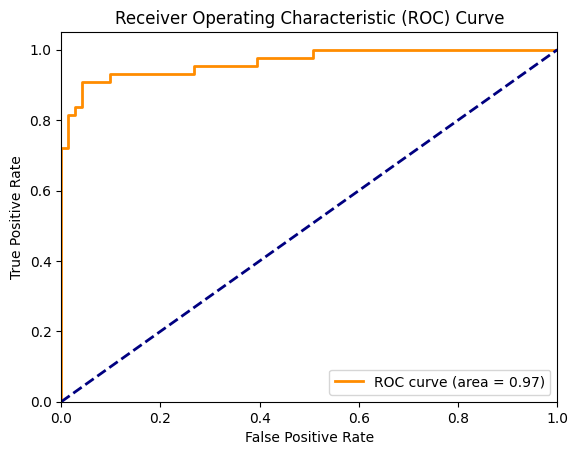

In [32]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_probs = torch.sigmoid(test_outputs).view(-1).cpu().numpy()
    test_predictions = torch.sign(test_outputs).view(-1).cpu().numpy()
    y_test_cpu = y_test.cpu().numpy()

fpr, tpr, _ = roc_curve((y_test_cpu + 1) // 2, test_probs)  # Convert labels back to 0 and 1 for ROC curve
roc_auc = auc(fpr, tpr)

accuracy = accuracy_score(y_test_cpu, test_predictions)
f1 = f1_score(y_test_cpu, test_predictions)
recall = recall_score(y_test_cpu, test_predictions)
precision = precision_score(y_test_cpu, test_predictions)
conf_matrix = confusion_matrix(y_test_cpu, test_predictions)

print(f'Test Accuracy: {accuracy:.8f}')
print(f'F1 Score: {f1:.8f}')
print(f'Recall: {recall:.8f}')
print(f'Precision: {precision:.8f}')

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

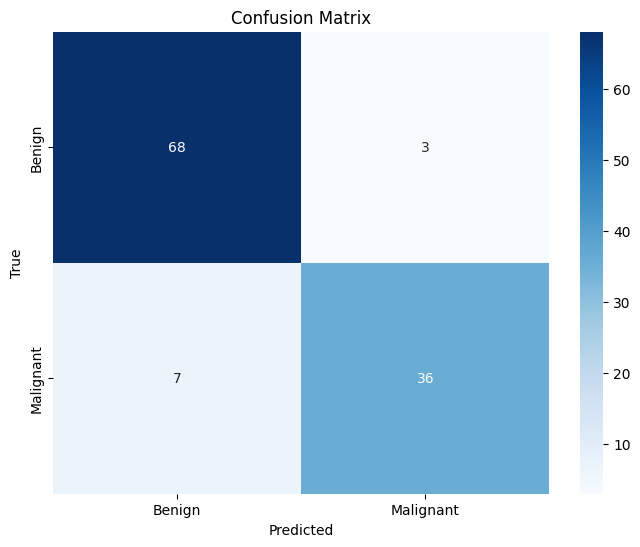

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##XGBoost

In [61]:
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values
y = (y == 'M').astype(int)  # Convert labels to 1 (Malignant) and 0 (Benign)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

model = XGBClassifier(random_state=42, tree_method='gpu_hist', gpu_id=0)

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Test Accuracy: {accuracy:.8f}')
print(f'F1 Score: {f1:.8f}')
print(f'Recall: {recall:.8f}')
print(f'Precision: {precision:.8f}')

In [ ]:
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Neural Network

In [34]:
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values
y = (y == 'M').astype(int)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [35]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [38]:
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
num_epochs = 50
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

Epoch [10/50], Loss: 0.00068597
Epoch [20/50], Loss: 0.00016188
Epoch [30/50], Loss: 0.00023190
Epoch [40/50], Loss: 0.00000177
Epoch [50/50], Loss: 0.00314415


In [44]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_probs = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()
    _, test_predictions = torch.max(test_outputs, 1)
    test_predictions = test_predictions.cpu().numpy()
    y_test_cpu = y_test.cpu().numpy()

fpr, tpr, _ = roc_curve(y_test_cpu, test_probs)
roc_auc = auc(fpr, tpr)

accuracy = accuracy_score(y_test_cpu, test_predictions)
f1 = f1_score(y_test_cpu, test_predictions)
recall = recall_score(y_test_cpu, test_predictions)
precision = precision_score(y_test_cpu, test_predictions)
conf_matrix = confusion_matrix(y_test_cpu, test_predictions)

print(f'Test Accuracy: {accuracy:.8f}')
print(f'F1 Score: {f1:.8f}')
print(f'Recall: {recall:.8f}')
print(f'Precision: {precision:.8f}')

Test Accuracy: 0.97368421
F1 Score: 0.96470588
Recall: 0.95348837
Precision: 0.97619048


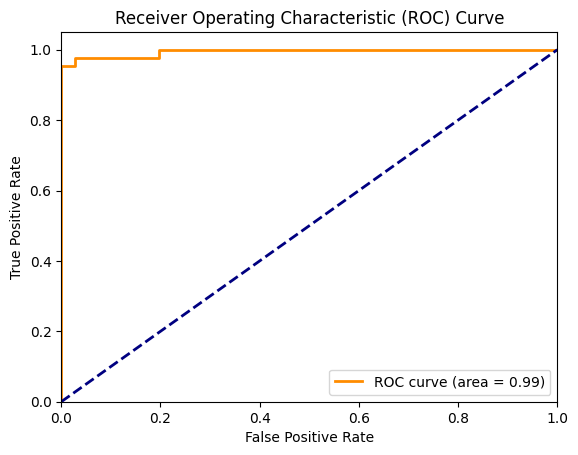

In [45]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

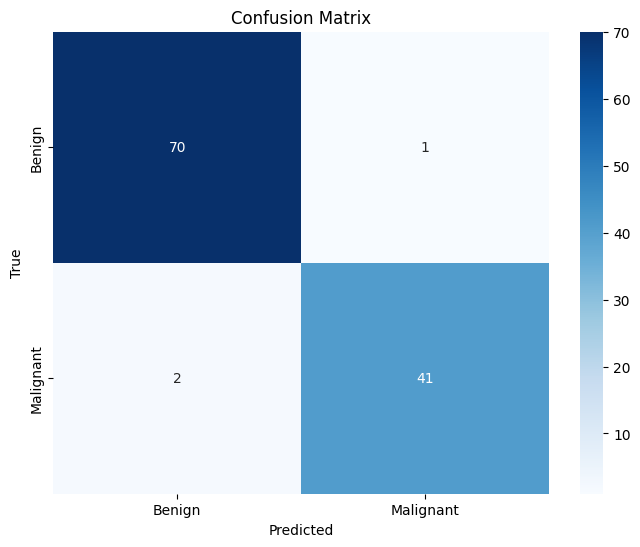

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##Neural Network (Fine Tuning)

In [47]:
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values
y = (y == 'M').astype(int)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [48]:
class RegularizedNN(nn.Module):
    def __init__(self):
        super(RegularizedNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [49]:
model = RegularizedNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [50]:
num_epochs = 50
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')

Epoch [10/50], Loss: 0.01947173
Epoch [20/50], Loss: 0.01166490
Epoch [30/50], Loss: 0.02399801
Epoch [40/50], Loss: 0.00036150
Epoch [50/50], Loss: 0.00031320


In [51]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_probs = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()
    _, test_predictions = torch.max(test_outputs, 1)
    test_predictions = test_predictions.cpu().numpy()
    y_test_cpu = y_test.cpu().numpy()

fpr, tpr, _ = roc_curve(y_test_cpu, test_probs)
roc_auc = auc(fpr, tpr)

accuracy = accuracy_score(y_test_cpu, test_predictions)
f1 = f1_score(y_test_cpu, test_predictions)
recall = recall_score(y_test_cpu, test_predictions)
precision = precision_score(y_test_cpu, test_predictions)
conf_matrix = confusion_matrix(y_test_cpu, test_predictions)

print(f'Test Accuracy: {accuracy:.8f}')
print(f'F1 Score: {f1:.8f}')
print(f'Recall: {recall:.8f}')
print(f'Precision: {precision:.8f}')

Test Accuracy: 0.98245614
F1 Score: 0.97674419
Recall: 0.97674419
Precision: 0.97674419


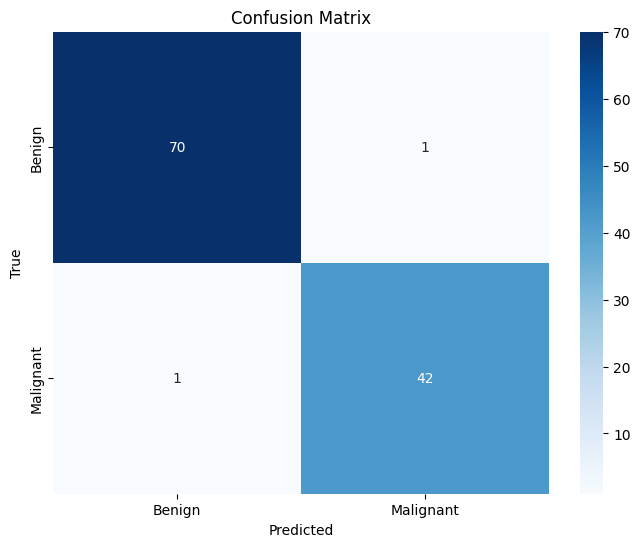

In [52]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##Gradient Boosting

In [55]:
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values
y = (y == 'M').astype(int)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [56]:
class WeakNN(nn.Module):
    def __init__(self, input_dim):
        super(WeakNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [57]:
num_weak_learners = 10
learning_rate = 0.1
weak_learners = []
pred_train = torch.zeros_like(y_train).to(device)
pred_test = torch.zeros_like(y_test).to(device)

for i in range(num_weak_learners):
    print(f'Training weak learner {i + 1}')

    weak_learner = WeakNN(X_train.shape[1]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(weak_learner.parameters(), lr=0.01)

    num_epochs = 100
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = weak_learner(X_train)
        loss = criterion(outputs, y_train - pred_train)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        pred_train += learning_rate * weak_learner(X_train)
        pred_test += learning_rate * weak_learner(X_test)

    weak_learners.append(weak_learner)

Training weak learner 1
Training weak learner 2
Training weak learner 3
Training weak learner 4
Training weak learner 5
Training weak learner 6
Training weak learner 7
Training weak learner 8
Training weak learner 9
Training weak learner 10


In [58]:
with torch.no_grad():
    final_predictions = torch.sigmoid(pred_test) > 0.5  # Sigmoid for binary classification
    final_predictions = final_predictions.float()
    y_test_cpu = y_test.cpu().numpy()
    final_predictions_cpu = final_predictions.cpu().numpy()
    accuracy = accuracy_score(y_test_cpu, final_predictions_cpu)
    f1 = f1_score(y_test_cpu, final_predictions_cpu)
    recall = recall_score(y_test_cpu, final_predictions_cpu)
    precision = precision_score(y_test_cpu, final_predictions_cpu)
    conf_matrix = confusion_matrix(y_test_cpu, final_predictions_cpu)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')

Test Accuracy: 0.6842
F1 Score: 0.7049
Recall: 1.0000
Precision: 0.5443


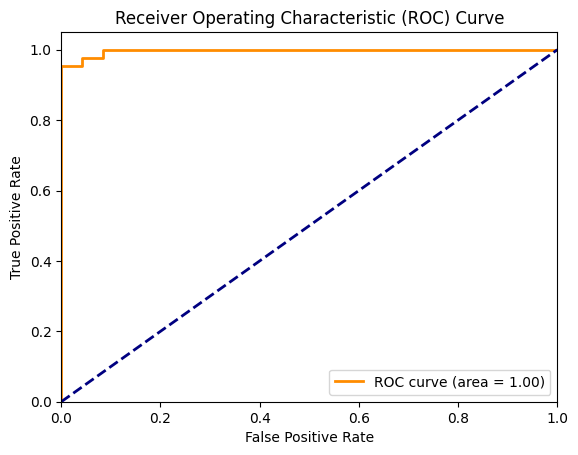

In [59]:
test_probs = torch.sigmoid(pred_test).cpu().numpy()  # Move to CPU before converting to numpy
fpr, tpr, _ = roc_curve(y_test_cpu, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

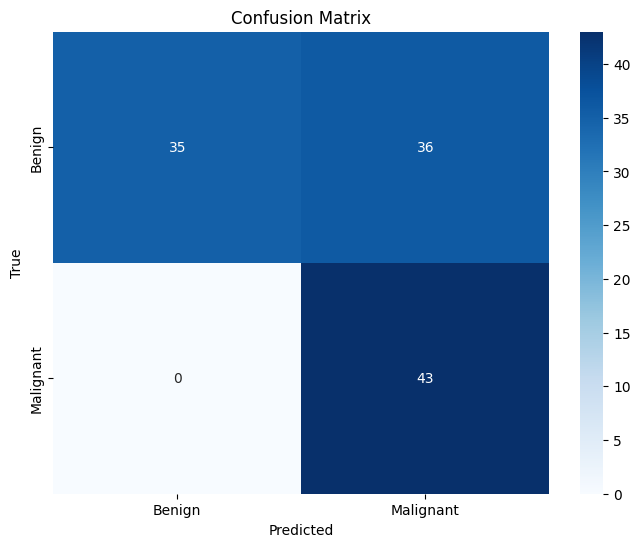

In [60]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()